## Описание:
Данный проект направлен на анализ рынка подержанных автомобилей в России с использованием данных, собранных с популярного автомобильного портала carro.ru.

# Задачи:

* Марка и модель автомобиля
* Год выпуска
* Пробег
* Тип кузова
* Тип двигателя (бензин, дизель, гибрид)
* Мощность двигателя
* Коробка передач (автомат, механика, вариатор)
* Цена

## Обработка и очистка данных:
* Преобразование собранных данных в удобный для анализа формат.
* Очистка данных от некорректных значений, дубликатов и выбросов.
* Обработка пропущенных значений с использованием подходящих стратегий (удаление, заполнение медианой/средним, импутация).

## Анализ данных: Проведение разведочного анализа данных (EDA) для выявления основных тенденций на рынке:

* Распределение цен на автомобили в зависимости от марки, модели, года выпуска, пробега и других параметров.
* Влияние технических характеристик (мощность двигателя, тип коробки передач) на стоимость автомобилей.
* Визуализация данных: Создание интерактивных визуализаций (с использованием библиотек Matplotlib, Seaborn)
* Гистограммы распределения цен Диаграммы рассеяния, показывающие зависимость цены от пробега и года выпуска
* Интерактивный dashboards для удобного анализа данных.

In [33]:
#Импортируем библиотеки
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(11,20))

<Figure size 1100x2000 with 0 Axes>

<Figure size 1100x2000 with 0 Axes>

In [12]:
#Указываем путь к JSON файлу с данными
url = '/home/max/git/maxtyrsa-1/Анализ рынка подержанных автомобилей: парсинг данных с carro.ru/carro.json'

In [13]:
#Загружаем JSON данные из указанного файла в DataFrame
df = pd.read_json(url)

In [14]:
#Выпрямляем вложенные данные из поля 'tech_specs'
tech = pd.json_normalize(df['tech_specs'])

In [15]:
# Удаляем исходное поле 'tech_specs' из DataFrame
df = df.drop('tech_specs', axis=1)

In [18]:
#Объединяем исходный DataFrame с выпрямленными данными
df = pd.concat([df, tech], axis=1)

In [19]:
#Приведение названий столбцов к общему стилю
df = df.rename(columns={'Год:': 'year', 'Коробка:': 'transmission', 'Пробег:': 'mileage', 'Объем:': 'volume', 'Мощность:': 'power', 'Двигатель:': 'engine', 'Тип кузова:': 'body_type', 'Привод:': 'drive', 'Владельцы:': 'owners'})

In [20]:
#Преобразуем столбец year в datetime и вычислик количество лет автомобилей в годах и добавим столбец age
df['year'] = df.year.astype('int')
df['age'] = pd.to_datetime('now').year - df.year

In [22]:
# Добавим строки с названием и моделью автомобилей
df['name'] = df.url.str.split('/').str[5]
df['model'] = df.url.str.split('/').str[6]

In [23]:
# Применение регулярных выражений для замены значений
df['price'] = df['price'].str.replace(r'\D+', '', regex=True).astype('int')
df['mileage'] = df['mileage'].str.replace(r'\D+', '', regex=True).astype('int')
df['volume'] = df['volume'].str.replace(' л', '').str.replace('\xa0', '').astype('float')
df['power'] = df['power'].str.replace(r'\D+', '', regex=True).astype('int')

/tmp/ipykernel_27978/4099152240.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax);


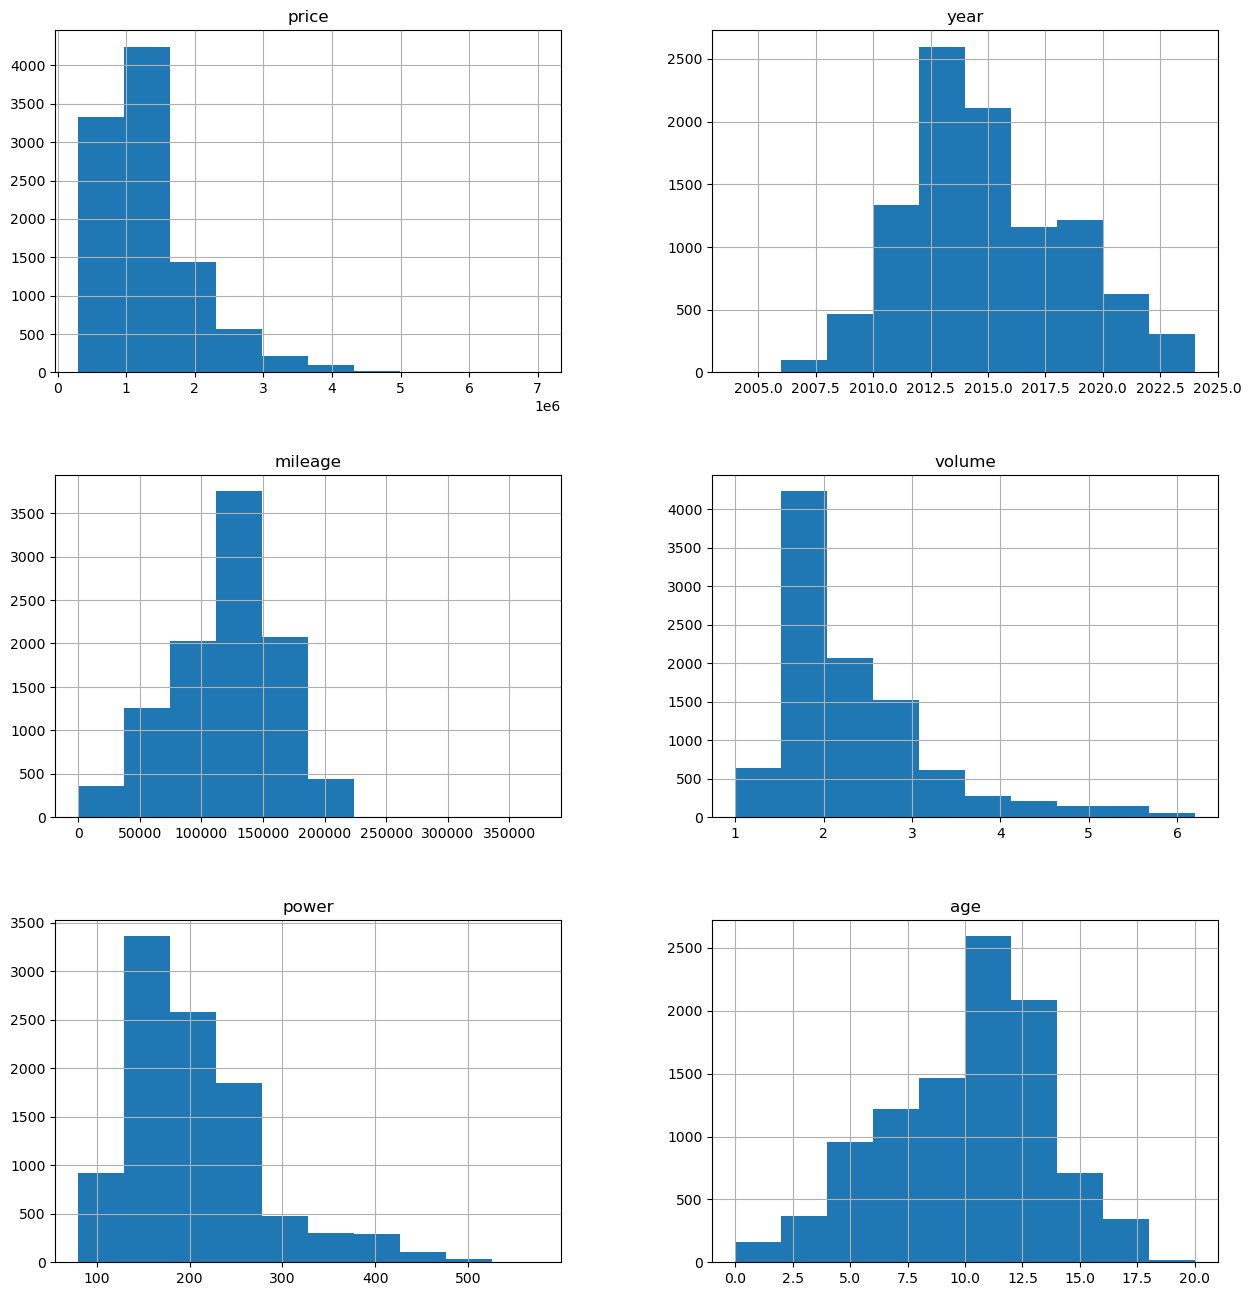

In [24]:
fig = plt.figure(figsize = (15,16))
ax = fig.gca()
df.hist(ax = ax);

#### На этом изображении показаны шесть гистограмм, каждая из которых представляет распределение отдельной переменной, связанной с данными о транспортном средстве:

##### цена: 
Распределение цен сильно смещено вправо, большинство цен сосредоточено в нижнем диапазоне и длинный хвост в сторону более высоких цен. Это указывает на множество менее дорогих автомобилей и меньшее количество очень дорогих.

##### год: 
Распределение по годам показывает пик около 2012-2015, что говорит о том, что многие автомобили в этом наборе данных относятся к той эпохе. Оно демонстрирует относительно равномерное распределение между 2005-2023.

##### пробег: 
Пробег показывает распределение с перекосом вправо. Это означает, что есть много автомобилей с небольшим пробегом и меньше с очень большим пробегом.

##### объем: 
Объем двигателя показывает несколько пиков, что предполагает несколько популярных размеров двигателя. Кажется, пик находится около 1,5-2,0 литров. Он смещен вправо.

##### мощность: 
Мощность двигателя показывает распределение, смещенное вправо. Многие транспортные средства имеют меньшую мощность, а некоторые имеют значительно большую мощность.

##### возраст: 
Гистограмма возраста показывает в основном симметричное распределение. Пик приходится на 10 лет, что говорит о большом количестве 10-летних автомобилей.

##### В целом: Гистограммы дают визуальное представление распределения ключевых характеристик набора данных транспортного средства. Правильная асимметрия в нескольких гистограммах (цена, пробег, объем, мощность) предполагает, что многие значения сосредоточены на нижнем конце шкалы, в то время как меньшее количество значений простирается на верхний конец. Это распространенная закономерность во многих наборах данных этого типа.

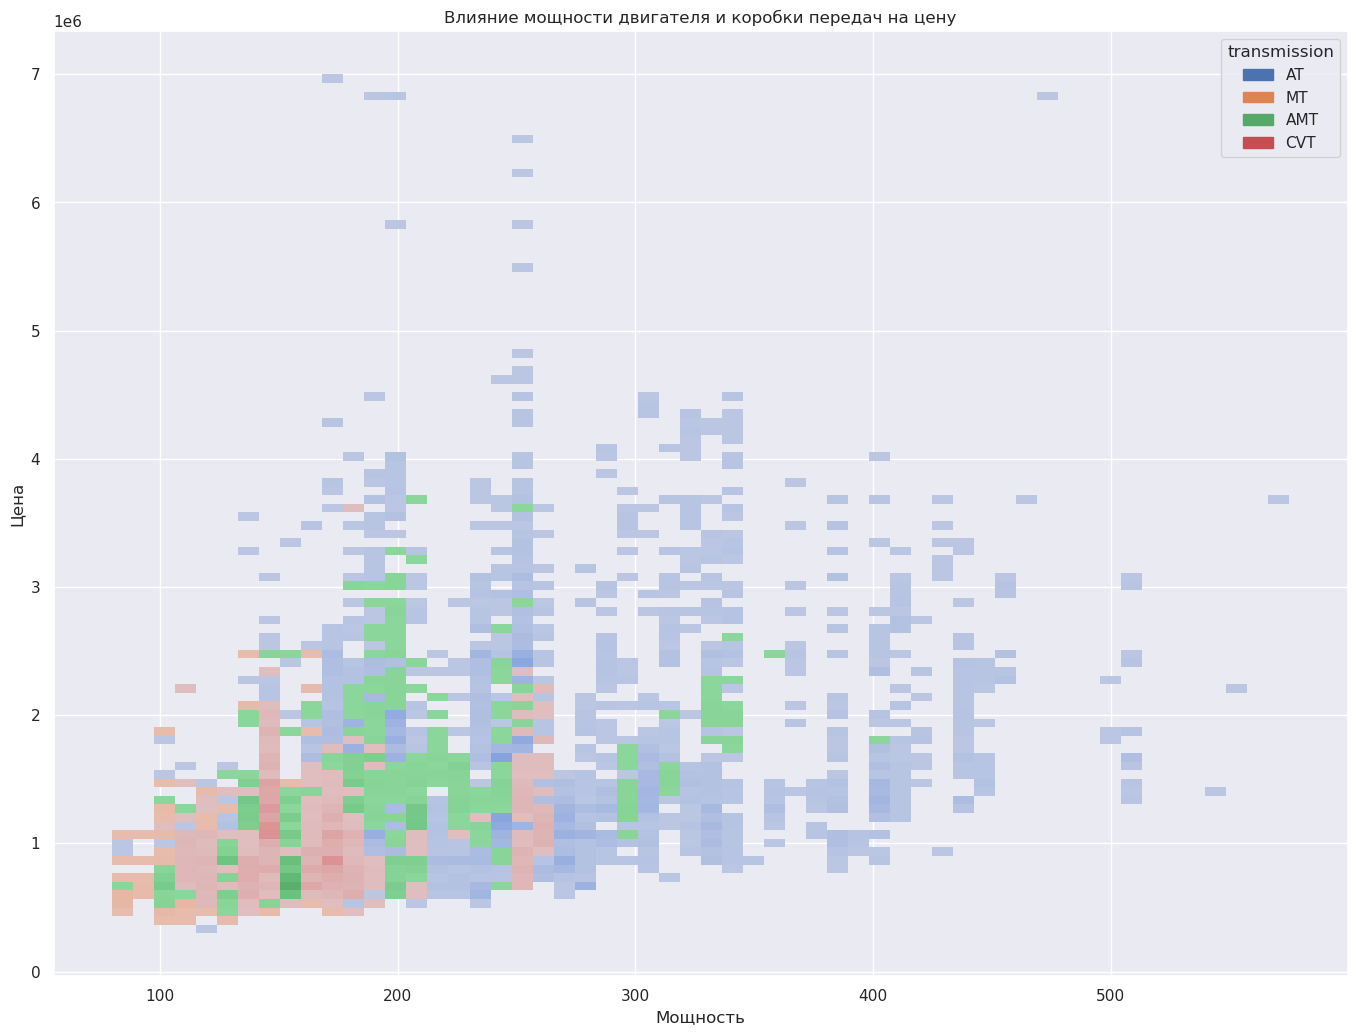

In [46]:
sns.histplot(data=df, x='power', y='price', hue='transmission');
plt.title('Влияние мощности двигателя и коробки передач на цену');
plt.xlabel('Мощность');
plt.ylabel('Цена');
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})


##### Общая тенденция: 
наблюдается общая тенденция к росту, предполагающая, что с ростом мощности двигателя цена также имеет тенденцию к росту. Это ожидаемо.

##### 
Тип трансмиссии: Различные цвета позволяют сравнивать цену и мощность для разных типов трансмиссии. Вы можете увидеть, какие типы трансмиссии более распространены при разных уровнях мощности и цены. Например, кажется, что автоматические трансмиссии (AT) более распространены в более высоких ценовых диапазонах и с более высокой выходной мощностью.

##### Кластеризация: 
Точки данных распределены неравномерно, что подразумевает кластеризацию схожих автомобилей на основе цены и мощности. Определенные комбинации мощности и цены встречаются чаще, чем другие.

##### Выбросы: 
некоторые точки данных разбросаны в областях с более низкой плотностью, что потенциально указывает на выбросы (транспортные средства с необычными сочетаниями цены и мощности для своего типа трансмиссии).

In [54]:
name_median_price = df.groupby(['name'], as_index=False).agg({'price': 'median'}).sort_values('price', ascending=False)

In [67]:
model_median_price = df.groupby(['model'], as_index=False).agg({'price': 'median'}).sort_values('price', ascending=False)

In [57]:
year_median_price = df.groupby(['year'], as_index=False).agg({'price': 'median'}).sort_values('price', ascending=False)

In [81]:
df[['volume', 'mileage', 'price', 'year', 'power', 'age']].corr()

,volume,mileage,price,year,power,age
volume,1.000000,0.293875,0.338396,-0.301244,0.862301,0.301244
mileage,0.293875,1.000000,-0.469223,-0.983659,0.203461,0.983659
price,0.338396,-0.469223,1.000000,0.473645,0.436797,-0.473645
year,-0.301244,-0.983659,0.473645,1.000000,-0.211535,-1.000000
power,0.862301,0.203461,0.436797,-0.211535,1.000000,0.211535
age,0.301244,0.983659,-0.473645,-1.000000,0.211535,1.000000


In [83]:
df_corr = df.apply(lambda x: pd.Categorical(x).codes)

In [85]:
df_corr.corr()

,name,price,url,year,transmission,mileage,volume,power,engine,body_type,drive,owners,age,model
name,1.000000,-0.144556,0.984789,-0.090696,0.049911,0.081501,-0.048963,-0.224571,0.042927,-0.049988,0.005499,-0.048481,0.090696,0.235378
price,-0.144556,1.000000,-0.132930,0.487951,-0.102380,-0.487113,0.374682,0.496051,0.365186,-0.184448,0.277387,-0.170970,-0.487951,0.022544
url,0.984789,-0.132930,1.000000,-0.120717,0.063292,0.112959,-0.029098,-0.194338,0.056913,-0.085331,0.042252,-0.019747,0.120717,0.284036
year,-0.090696,0.487951,-0.120717,1.000000,-0.018327,-0.976422,-0.311182,-0.215686,-0.030683,0.081638,-0.106831,-0.374622,-1.000000,0.013461
transmission,0.049911,-0.102380,0.063292,-0.018327,1.000000,0.018747,0.047786,-0.106686,-0.049179,-0.139646,0.016372,0.005340,0.018327,0.045326
mileage,0.081501,-0.487113,0.112959,-0.976422,0.018747,1.000000,0.300582,0.208684,0.026814,-0.080405,0.097407,0.410093,0.976422,-0.015709
volume,-0.048963,0.374682,-0.029098,-0.311182,0.047786,0.300582,1.000000,0.848546,0.109856,-0.287994,0.402645,0.117721,0.311182,0.077490
power,-0.224571,0.496051,-0.194338,-0.215686,-0.106686,0.208684,0.848546,1.000000,0.087753,-0.221534,0.395005,0.106357,0.215686,0.022727
engine,0.042927,0.365186,0.056913,-0.030683,-0.049179,0.026814,0.109856,0.087753,1.000000,-0.230486,0.244893,-0.015336,0.030683,0.161477
body_type,-0.049988,-0.184448,-0.085331,0.081638,-0.139646,-0.080405,-0.287994,-0.221534,-0.230486,1.000000,-0.579957,-0.058041,-0.081638,-0.397283


### Сильные положительные корреляции (выше 0,8):

* name и url(0,98): Эта чрезвычайно высокая корреляция ожидаема. nameИ urlвнутренне связаны; у каждого автомобиля есть уникальное имя и соответствующий URL. Это не значимая корреляция для анализа.
* mileage и age(0,98): Очень сильная положительная корреляция, указывающая на то, что старые автомобили, как правило, имеют больший пробег. Это ожидаемо и весьма логично. Эта высокая корреляция также может привести к мультиколлинеарности в регрессионных моделях.
* volume и power(0,85): Сильная положительная корреляция, указывающая на то, что большие объемы двигателя связаны с большей мощностью двигателя. Это также весьма ожидаемо.

### Умеренные положительные корреляции (от 0,4 до 0,8):

* price и year(0,49): Новые автомобили, как правило, дороже.
* price и power(0,50): Более мощные автомобили, как правило, имеют более высокую цену.
* volume и price(0,37): Больший объем двигателя связан с более высокими ценами.
* power и price(0,50): Более высокая мощность двигателя коррелирует с более высокими ценами.

### Умеренные отрицательные корреляции (от -0,4 до -0,8):

* price и mileage(-0,49): Больший пробег ассоциируется с меньшими ценами. Это ожидаемо на рынке подержанных автомобилей.
* price и age(-0,49): Старые автомобили, как правило, имеют более низкие цены.
* year и mileage(-0,98): Эта сильная отрицательная корреляция связана с сильной положительной корреляцией между mileageи ageи является ожидаемой.